## 1. Packages

In [1]:
import os
import pandas as pd
import numpy as np

%matplotlib inline
import src.upload_utils as ut
import constants as const
import src.draw_utils as du
import src.upload_yolo_utils as yu
import src.yolo_utils as yolo_utils

## 2. Data

### 2.1 Load data from GoogleDrive and unzip

In [5]:
ut.download_file_from_google_drive(id=const.FILE_ID, 
                                   destination=const.DATA_ZIP)

[{upload_utils.py:186} INFO - response = <Response [200]>
[{upload_utils.py:205} INFO - Start download file, size = 0


data.zip: 105MB [03:37, 485kB/s]  

[{upload_utils.py:213} INFO - Successfully downloaded


In [6]:
ut.unzip_data(zip_file=const.DATA_ZIP)

[{upload_utils.py:225} INFO - Unzip = data.zip
[{upload_utils.py:228} INFO - Successfully unzip


### 2.2. Load data

In [12]:
mri_df_raw = ut.load_data(from_dir=const.PATH_FILES)

[{upload_utils.py:29} INFO - Load from /Users/valeriakaravaeva/Documents/git/_LK/mri_detection/data/descr/ 12 files
[{upload_utils.py:34} INFO - Concat list of data frames
[{upload_utils.py:38} INFO - Finish read df = (916, 20)


### 2.3. Data exploration

In [13]:
mri_df_raw.head()

,ID,Исследователь,Кейс,Файлы,Протокол,XML,Файлы разметки,На срезе визуализируются межпозвоночные диски,Шейный межпозвоночный диск - здоровый,Шейный межпозвоночный диск - с подозрением на патологию,Шейный межпозвоночный диск - патологический,грудной межпозвоночный диск - здоровый,грудной межпозвоночный диск - с подозрением на паталогию,грудной межпозвоночный диск - патологический,поясничный межпозвоночный диск - здоровый,поясничный межпозвоночный диск - с подозрением на патологию,поясничный межпозвоночный диск - патологический,крестцовый межпозвоночный диск - здоровый,крестцовый межпозвоночный диск - с подозрением на патологию,крестцовый межпозвоночный диск - патологический
0,2872,Denis Shpak,4773 - dcm-dromanov,img_00215.jpg/n,MRI_NECK_SAG_prot_hern,<annotation>\r\n <filename>https://...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3144,Denis Shpak,4774 - dcm-dromanov,img_00226.jpg/n,MRI_NECK_SAG_prot_hern,<annotation>\r\n <filename>https://...,NaN,Визуализируются (можно размечать),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5571,Denis Shpak,4791 - dcm-dromanov,img_00200.jpg/n,MRI_NECK_SAG_prot_hern,NaN,NaN,Визуализируются (можно размечать),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5572,Denis Shpak,4791 - dcm-dromanov,img_00200.jpg/n,MRI_NECK_SAG_prot_hern,NaN,NaN,Визуализируются (можно размечать),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5573,Denis Shpak,4791 - dcm-dromanov,img_00200.jpg/n,MRI_NECK_SAG_prot_hern,NaN,NaN,Визуализируются (можно размечать),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
mri_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 20 columns):
ID                                                             916 non-null int64
Исследователь                                                  916 non-null object
Кейс                                                           916 non-null object
Файлы                                                          916 non-null object
Протокол                                                       916 non-null object
XML                                                            892 non-null object
Файлы разметки                                                 0 non-null float64
На срезе визуализируются межпозвоночные диски                  896 non-null object
Шейный межпозвоночный диск - здоровый                          0 non-null float64
Шейный межпозвоночный диск - с подозрением на патологию        0 non-null float64
Шейный межпозвоночный диск - патологический                    0 non-

In [15]:
mri_df_raw['На срезе визуализируются межпозвоночные диски'].value_counts()

Не визуализируются (срез не пригоден для разметки)    531
Визуализируются (можно размечать)                     365
Name: На срезе визуализируются межпозвоночные диски, dtype: int64

In [16]:
mri_df_raw = mri_df_raw[mri_df_raw['На срезе визуализируются межпозвоночные диски'] == 'Визуализируются (можно размечать)']

#### We can see columns with trash (all rows is null) and columns which we need to delete. Let's start data preprocessing (include XML parsing)

In [17]:
mri_preproc = ut.parse_xml(df=mri_df_raw)
mri_preproc.head()

[{upload_utils.py:78} INFO - Start preprocessing data, shape = (365, 20)
[{upload_utils.py:79} INFO - Drop NaN columns of XML
[{upload_utils.py:84} INFO - Start parse XML, shape = (356, 20)


,date,deleted,file,height,id,imagesize,name,occluded,parts,verified,width,x,x_center,y,y_center
0,28-Aug-2018 10:10:28,0,img_00226.jpg,12,3144,"384, 384",shejnyj-mezhpozvonochnyj-disk-zdorovyj,no,"0 {'hasparts': None, 'ispartof': None}\n1 ...",0,29,172,186.5,107,113.0
1,28-Aug-2018 10:10:35,0,img_00226.jpg,12,3144,"384, 384",shejnyj-mezhpozvonochnyj-disk-zdorovyj,no,"0 {'hasparts': None, 'ispartof': None}\n1 ...",0,25,168,180.5,132,138.0
2,28-Aug-2018 10:10:41,0,img_00226.jpg,12,3144,"384, 384",shejnyj-mezhpozvonochnyj-disk-zdorovyj,no,"0 {'hasparts': None, 'ispartof': None}\n1 ...",0,24,164,176.0,156,162.0
3,28-Aug-2018 10:27:23,0,img_00226.jpg,16,3144,"384, 384",shejnyj-mezhpozvonochnyj-disk-patologicheskij,no,"0 {'hasparts': None, 'ispartof': None}\n1 ...",0,25,164,176.5,178,186.0
4,28-Aug-2018 10:27:41,0,img_00226.jpg,19,3144,"384, 384",shejnyj-mezhpozvonochnyj-disk-zdorovyj,no,"0 {'hasparts': None, 'ispartof': None}\n1 ...",0,27,165,178.5,203,212.5


#### We can see a lot of columns. But we can drop a few columns because they don't contain information.
We should research: `imagesize`, `name`, `verified`, `occluded`, `deleted`, `date`

In [18]:
mri_preproc.id = mri_preproc.id.astype(object)

In [19]:
mri_preproc.describe(include=np.object)

,date,deleted,file,id,imagesize,name,occluded,parts,verified
count,1577,2694,2694,2694,2694,2694,2694,2694,2694
unique,1577,2,356,356,2,8,1,12,1
top,30-Aug-2018 21:20:40,0,img_00370.jpg,3928,"384, 384",shejnyj-mezhpozvonochnyj-disk-zdorovyj,no,"0 {'hasparts': None, 'ispartof': None}\n1 ...",0
freq,1,2676,13,13,2675,961,2694,700,2694


Let's see how much class in `deleted` and `imagesize`. Can we leave only one class? (We can see below, that yes)

We can see that `verified`, `occluded`, `parts`, `date` are not information. 

Function `preproc_data(df)` filters our data:
* **deleted** = 0
* **imagesize** = 384, 384
* **type_mri** = shejnyj

In [20]:
mri_filter, cat_label = ut.preproc_data(df=mri_preproc, columns=const.COLUMNS)

mri_filter.head()

[{upload_utils.py:148} INFO - Adding column type_mri
[{upload_utils.py:151} INFO - Stats by type_mri {'shejnyj': 1702, 'grudnoj': 990, 'protrusion': 1, 'hernia': 1}
[{upload_utils.py:152} INFO - Stats by deleted {'0': 2676, '1': 18}
[{upload_utils.py:153} INFO - Stats by imagesize {'384, 384': 2675, '512, 512': 19}
[{upload_utils.py:155} INFO - Filtering data, shape before = (2694, 16)
[{upload_utils.py:160} INFO - Adding column type of disk
[{upload_utils.py:163} INFO - Adding column label (category)
[{upload_utils.py:168} INFO - Filtering data, shape before = (1665, 18)
[{upload_utils.py:169} INFO - Category {0: 'patologicheskij', 1: 'spodozreniem', 2: 'zdorovyj'}
[{upload_utils.py:170} INFO - Filter by columns: id, label, file, type_disk, height, width, x, y, x_center, y_center


,id,label,file,type_disk,height,width,x,y,x_center,y_center
0,3144,2,img_00226.jpg,zdorovyj,12,29,172,107,186.5,113.0
1,3144,2,img_00226.jpg,zdorovyj,12,25,168,132,180.5,138.0
2,3144,2,img_00226.jpg,zdorovyj,12,24,164,156,176.0,162.0
3,3144,0,img_00226.jpg,patologicheskij,16,25,164,178,176.5,186.0
4,3144,2,img_00226.jpg,zdorovyj,19,27,165,203,178.5,212.5


### 2.4. Stats by clean data

In [21]:
mri_filter.describe(include=np.object)

,id,label,file,type_disk
count,1665,1665,1665,1665
unique,339,3,339,3
top,5590,2,img_00200.jpg,zdorovyj
freq,8,935,8,935


In [22]:
mri_filter.describe()

,height,width,x,y,x_center,y_center
count,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000
mean,19.799399,37.666667,159.067267,162.058258,177.900601,171.957958
std,4.242995,6.972301,21.081807,42.243679,20.562241,42.514640
min,9.000000,19.000000,106.000000,57.000000,124.500000,69.000000
25%,17.000000,33.000000,144.000000,131.000000,163.500000,140.000000
50%,19.000000,38.000000,159.000000,163.000000,177.000000,172.500000
75%,22.000000,42.000000,173.000000,193.000000,192.500000,203.500000
max,51.000000,70.000000,214.000000,345.000000,229.500000,356.000000


Distribution of out class:

In [23]:
mri_filter['type_disk'].value_counts()

zdorovyj           935
patologicheskij    400
spodozreniem       330
Name: type_disk, dtype: int64

Good!

## 3. Draw

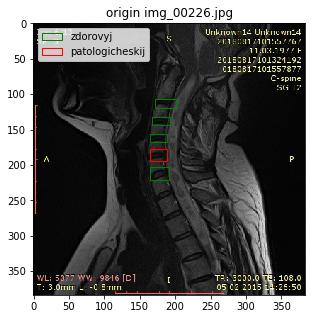

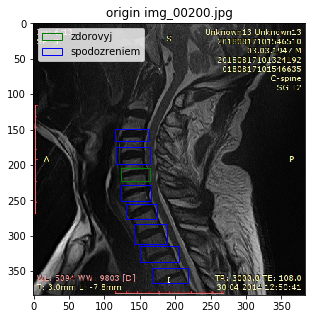

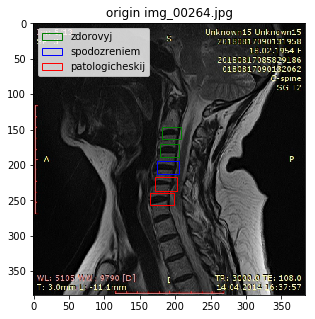

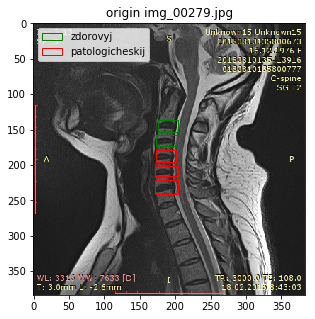

In [27]:
for img in mri_filter['file'].unique()[0:4]:
    plots = du.draw_img(df=[mri_filter], 
                        img_name=img,
                        types_df=['origin'],
                        dir_img=const.PATH_IMG, 
                        color_patch={'0': 'r', '1': 'b', '2': 'g'}, 
                        figsize=(5, 5))

In [28]:
unique_files = mri_filter['file'].unique()

In [29]:
N = len(unique_files)
TEST_NUM = int(0.3*N)

## 4. Prepare data for yolo

### 4.1. Copy obj.names and obj.data to data/

In [19]:
yu.copy_files(dir_from=const.ROOT + '/cfg/',
              dir_to=const.PATH_DARKNET + 'data/',
              files=['obj.names', 'obj.data'])

[{upload_yolo_utils.py:28} INFO - Copy from /Users/valeriakaravaeva/Documents/git/_LK/mri_detection/cfg/ 
 to 
 /Users/valeriakaravaeva/Documents/git/_LK/mri_detection/darknet/data/
[{upload_yolo_utils.py:34} INFO - Success copy 2 files


### 4.2. Copy all images to data/obj

In [20]:
yu.copy_files(dir_from=const.PATH_IMG,
              dir_to=const.PATH_DARKNET + 'data/obj',
              files=unique_files)

[{upload_yolo_utils.py:28} INFO - Copy from /Users/valeriakaravaeva/Documents/git/_LK/mri_detection/data/images/ 
 to 
 /Users/valeriakaravaeva/Documents/git/_LK/mri_detection/darknet/data/obj
[{upload_yolo_utils.py:34} INFO - Success copy 339 files


### 4.3. Create for each images txt file with polygon (to data/obj)

In [21]:
yu.img_txt(df=mri_filter,
           dir_to=const.PATH_DARKNET + 'data/obj', img_size=const.IMG_SIZE,
           columns_yolo=const.COLUMNS_YOLO,
           imgs=unique_files)

[{upload_yolo_utils.py:40} INFO - Create txt file to dir 
 /Users/valeriakaravaeva/Documents/git/_LK/mri_detection/darknet/data/obj
[{upload_yolo_utils.py:48} INFO - Success create 339 files txt


### 4.4. Copy create test and train images and save to data/

In [36]:
test_set, train_set = yu.test_train_files(imgs=unique_files, 
                                          test_size=TEST_NUM, 
                                          dir_to_file='data/obj/',
                                          dir_to=const.PATH_DARKNET + 'data/')

[{upload_yolo_utils.py:61} INFO - Write test file 101 to 
 /Users/valeriakaravaeva/Documents/git/_LK/mri_detection/darknet/data/
[{upload_yolo_utils.py:67} INFO - Write train file 238 to 
 /Users/valeriakaravaeva/Documents/git/_LK/mri_detection/darknet/data/


## 5. Evaluate

### 5.1. Change directory

In [37]:
import os
os.chdir(const.ROOT + '/darknet')

### 5.2. Load network (cfg, data, weight)

In [38]:
net, meta = yolo_utils.load_data(cfg=const.CFG_YOLO, 
                                 data=const.DATA_YOLO, 
                                 weights=const.WEIGHT_YOLO)

[{yolo_utils.py:182} INFO - Encode to ascii
[{yolo_utils.py:187} INFO - Load net b'/Users/valeriakaravaeva/Documents/git/_LK/mri_detection/darknet/cfg/yolo.cfg' b'/Users/valeriakaravaeva/Documents/git/_LK/mri_detection/darknet/backup/yolo.weights'
[{yolo_utils.py:190} INFO - Load meta b'/Users/valeriakaravaeva/Documents/git/_LK/mri_detection/darknet/data/obj.data'


### 5.3. Create DataFrame for predict

In [39]:
yolo_results_test_list = []
for i in range(len(test_set)):
    results = yolo_utils.detect_df(net=net, 
                               meta=meta,
                               img=test_set[i],
                               cat_label=cat_label, 
                               columns=const.COLUMNS_YOLO,
                               threshold=.2)
    yolo_results_test_list.append(results)
yolo_results_test = pd.concat(yolo_results_test_list)

In [40]:
yolo_results_test.head()

,label,x_center,y_center,width,height,x,y,type_disk,file
0,0,186.325974,172.654526,42.385658,19.317377,165.133144,162.995837,patologicheskij,img_00111.jpg
1,1,185.010742,142.759277,40.017822,19.808296,165.001831,132.855129,spodozreniem,img_00111.jpg
2,1,186.556793,114.015381,37.637360,19.550709,167.738113,104.240026,spodozreniem,img_00111.jpg
3,0,193.828171,204.841888,45.370903,19.576759,171.142719,195.053509,patologicheskij,img_00111.jpg
4,0,189.165009,198.583099,44.606239,18.398872,166.861889,189.383663,patologicheskij,img_00111.jpg


### 5.4. Visualize results

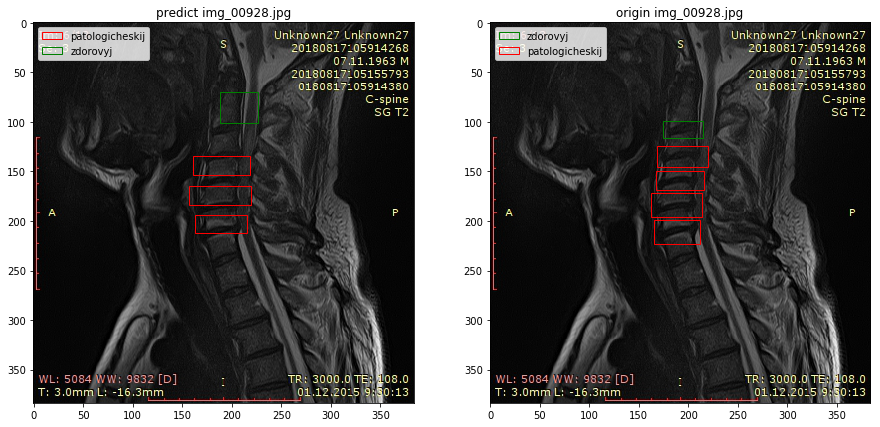

In [41]:
du.draw_img(df=[yolo_results_test, mri_filter], 
         types_df = ['predict', 'origin'],
         img_name='img_00928.jpg', 
         dir_img=const.PATH_IMG, 
         figsize=(15, 15),
         color_patch={'0': 'r', '1': 'b', '2': 'g'})